## Using Monte Carlo Control

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [1]:
import random, numpy as np

In [2]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [3]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Part 2: Monte Carlo Control Implementation

In [4]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

number_of_episodes = 10000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10)
    dealer_value = random.randint(1, 10)
    s = (dealer_value, player_value)
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    episode_trajectory = []

    while True:
        s_new, r = step(s, a)
        episode_trajectory.append((s, a, r))

        if r != 0:
            break

        s = s_new
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy

    G = 0 # Monte Carlo return (Cumulative reward)

    for t in reversed(range(len(episode_trajectory))):
        s_t, a_t, r_t = episode_trajectory[t]
        G += r_t

        first_visit = True
        for j in range(t):
            prev_state, prev_action, _ = episode_trajectory[j]
            if prev_state == s_t and prev_action == a_t:
                first_visit = False
                break

        if first_visit and s_t[1] >= 1 and s_t[1] <= 21:
            N[s_t[0], s_t[1], a_t] += 1
            alpha = 1 / N[s_t[0], s_t[1], a_t]
            V[s_t[0], s_t[1], a_t] += alpha * (G - V[s_t[0], s_t[1], a_t])


In [5]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.56790515 -0.52683431 -0.49412435 -0.45779294 -0.42846005
  -0.40669467 -0.38128104 -0.33728858 -0.26628399 -0.18592492 -0.08803992
  -0.14070785 -0.17797808 -0.21751378 -0.25671642 -0.30051585 -0.33647173
  -0.4073741  -0.51668255 -0.62340426 -1.        ]
 [ 0.         -0.574226   -0.53068806 -0.49302481 -0.46133674 -0.42547455
  -0.39668856 -0.38591777 -0.33847381 -0.26777515 -0.18573356 -0.09338825
  -0.13615411 -0.1735073  -0.2227491  -0.26317445 -0.30147599 -0.34002816
  -0.41176471 -0.48550047 -0.60103093 -1.        ]
 [ 0.         -0.57243297 -0.53066996 -0.49756689 -0.46780722 -0.42877361
  -0.4034101  -0.38699974 -0.33934302 -0.27218512 -0.18987273 -0.09488198
  -0.14144338 -0.

In [6]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
Z_diff = Z_1 - Z_0
optimal_policy = np.argmax(V, axis=2)

In [7]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         -0.52321997 -0.52059578 -0.52416439 -0.52263039 -0.52539472
  -0.51759988 -0.52026064 -0.52542499 -0.52394912 -0.5256961 ]
 [ 0.         -0.51912697 -0.52602529 -0.51794714 -0.52058106 -0.51862301
  -0.52460146 -0.52376305 -0.52771744 -0.52416956 -0.52607115]
 [ 0.         -0.49412435 -0.49302481 -0.49756689 -0.48318059 -0.49363468
  -0.49147827 -0.49764246 -0.50072613 -0.49441033 -0.48717623]
 [ 0.         -0.45779294 -0.46133674 -0.46780722 -0.45384273 -0.46139571
  -0.4604043  -0.45945563 -0.4646285  -0.46022987 -0.46424935]
 [ 0.         -0.42846005 -0.42547455 -0.42877361 -0.42896359 -0.43589801
  -0.4308437  -0.43292549 -0.43597379 -0.43045781 -0.4277189 ]
 [ 0.         -0.40669467 -0.39668856 -0.4034101  -0.39892722 -0.40453499
  -0.40151769 -0.40246219 -0.41101722 -0.40703936 -0.40757048]
 [ 0.         -0.381281

### Part 3: Plotting the value function and optiimal policy

In [8]:
import matplotlib.pyplot as plt

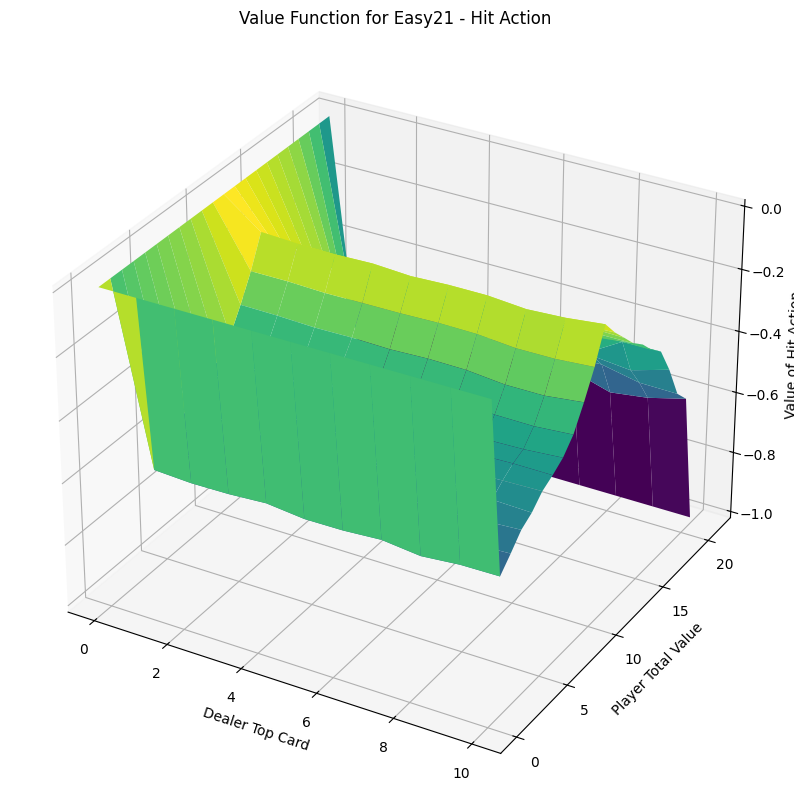

In [9]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

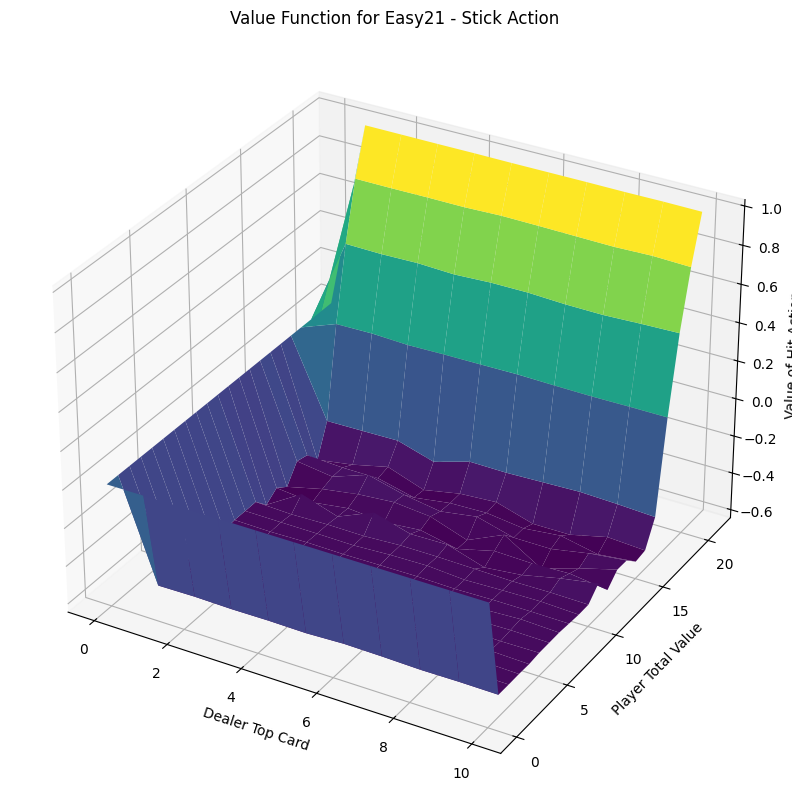

In [10]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

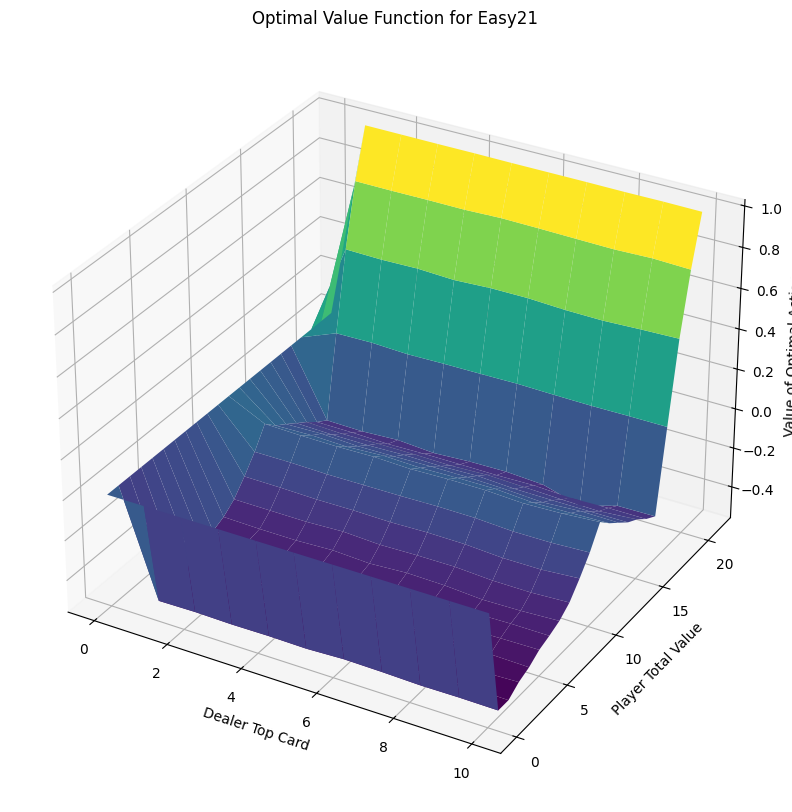

In [11]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

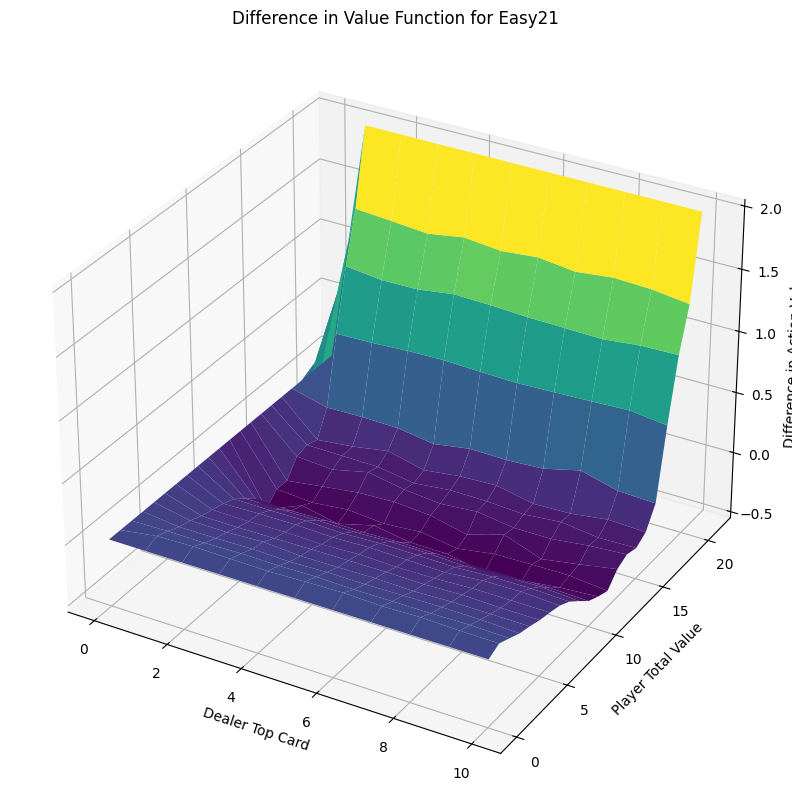

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_diff, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Difference in Action Values')
ax.set_title('Difference in Value Function for Easy21')
plt.show()

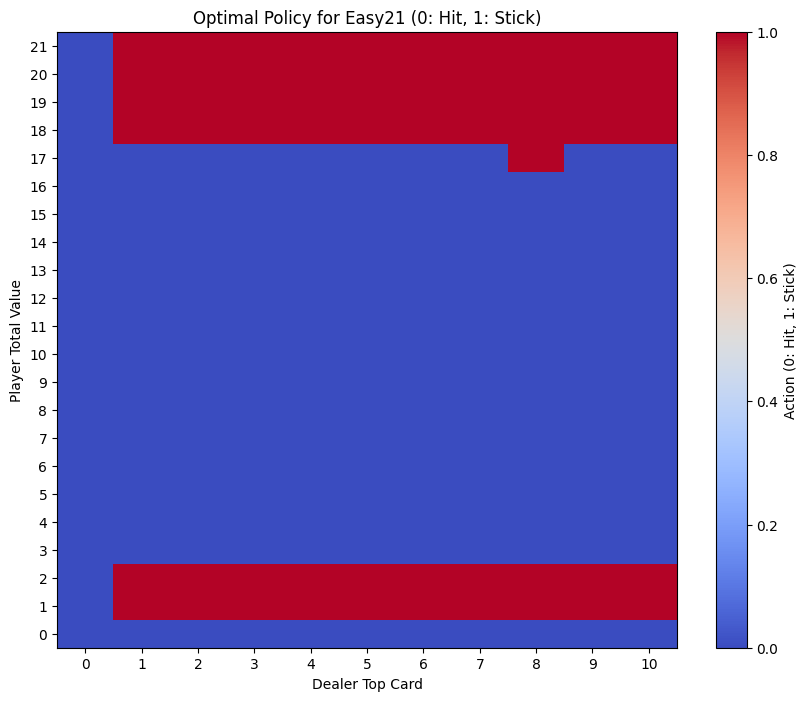

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()